In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('tracks_features.csv')
df = df[df['year'] >= 1922]
df.head()

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


In [3]:
def obter_decada(linha):
    ano = str(linha['year'])
    return int(ano[:3] + "0")

df['decade'] = df.apply (lambda x: obter_decada(x), axis=1)

In [4]:
df = df[df['decade'] != "00"]
df.groupby('decade').size()

decade
1920       436
1930       453
1940       653
1950      3159
1960      8784
1970     17183
1980     28595
1990    153049
2000    423753
2010    498089
2020     69726
dtype: int64

### UtilIzando o KNN para classificar músicas do período anterior
##### Músicas entre 1922 e 1979

In [5]:
df_1920 = df[df['decade'] == 1920].sample(n=400)
df_1930 = df[df['decade'] == 1930].sample(n=400)
df_1940 = df[df['decade'] == 1940].sample(n=400)
df_1950 = df[df['decade'] == 1950].sample(n=400)
df_1960 = df[df['decade'] == 1960].sample(n=400)
df_1970 = df[df['decade'] == 1970].sample(n=400)

df_1922_a_1980 = pd.concat([df_1920, df_1930, df_1940, df_1950, df_1960, df_1970], ignore_index=True, sort=False)

df_1922_a_1980.groupby('decade').size()

decade
1920    400
1930    400
1940    400
1950    400
1960    400
1970    400
dtype: int64

In [6]:
X = df_1922_a_1980[['danceability', 'energy', 'key', 'loudness', 'mode', 
        'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
        'valence', 'tempo', 'duration_ms', 'time_signature']]
y = df_1922_a_1980['decade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

#### Gerando o melhor valor para k

In [8]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
params = {'n_neighbors': np.arange(10, 200, 5)}
knn_gscv = GridSearchCV(knn, params)
knn_gscv.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195])})

In [9]:
best_k = knn_gscv.best_params_['n_neighbors']
print('Melhor resultado: ', best_k)

Melhor resultado:  105


#### Classificação

In [10]:
classifier = KNeighborsClassifier(
    n_neighbors=best_k, 
    p=6, # quantidade de décadas a serem testadas
    metric='euclidean')

In [11]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=105, p=6)

In [12]:
y_pred = classifier.predict(X_test)

In [13]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[84 18 12  1  0  1]
 [74 30 15  4  1 11]
 [42 18 49  5  3  1]
 [33 12 39 23  9 13]
 [17 10 35  9 12 30]
 [13  8 19 11  6 52]]


In [14]:
# # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
print('f1_score: ', f1_score(y_test, y_pred, average='weighted'))

f1_score:  0.3200756990720304


In [15]:
print('accuracy_score:', accuracy_score(y_test, y_pred))

accuracy_score: 0.3472222222222222


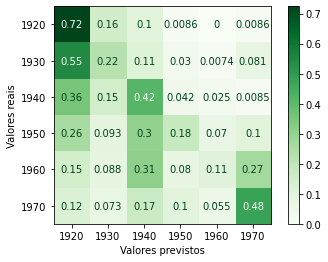

In [16]:
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             display_labels=[1920, 1930, 1940, 1950, 1960, 1970],
                             cmap=plt.cm.Greens,
                             normalize='true')
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.show()